In [1]:
%matplotlib inline

In [52]:
import os

import numpy as np
import pandas as pd

In [18]:
WORDS_COUNTS_FILEPATH = os.path.join('hack_wordle_ui', 'public', 'words_counts.txt')

In [22]:
MAX_WORD_LENGTH = 5

In [4]:
if not os.path.exists('python'):
    os.chdir('..')

In [5]:
def read_word_counts():
    with open(WORDS_COUNTS_FILEPATH, 'r') as f:
        return f.read()

In [6]:
def create_df():
    word_counts_text = read_word_counts()
    words_counts_list = []
    for words_count_line in word_counts_text.strip().split('\n'):
        word, count = words_count_line.split(' ')
        words_counts_list.append({
            'word': word,
            'count': int(count)
        })
    return pd.DataFrame(words_counts_list)
df = create_df()

In [7]:
from collections import Counter

In [103]:
c = Counter()
for word in df.word:
    c.update(word)
#     break

In [12]:
letters = sorted(c.keys())

In [13]:
counts_list = []
for letter in letters:
    counts_list.append({
        'letter': letter,
        'counts': c[letter]
    })
df_counts = pd.DataFrame(counts_list)

<AxesSubplot:xlabel='letter'>

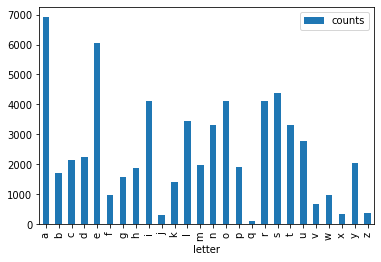

In [14]:
df_counts.plot.bar(x='letter', y='counts')

### Get Letter Position Frequencies

In [32]:
LIMIT = 100000000000

In [33]:
letter_positions = {}
for letter in letters:
    letter_positions[letter] = [0] * MAX_WORD_LENGTH


In [102]:
for word in df.word.head(LIMIT):
    for i, letter in enumerate(word):
        letter_positions[letter][i] += 1
# letter_positions

In [90]:
def letter_position_percent(row):
    total = np.sum(row)
    return row / total

#letter_positions_df.apply(letter_position_percent, axis=1)

<AxesSubplot:>

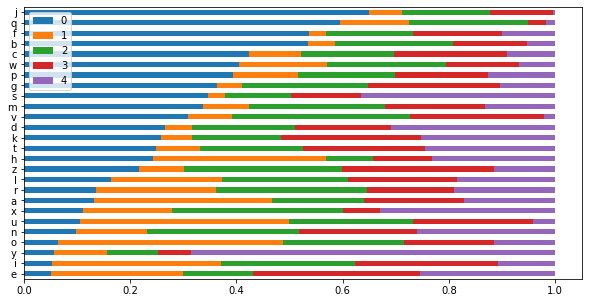

In [101]:
letter_positions_df = pd.DataFrame(letter_positions)
letter_positions_df = letter_positions_df.T
# letter_positions_df['letter']  = letter_positions_df.index
# letter_positions_df = letter_positions_df.reset_index(drop=True)
letter_positions_df = letter_positions_df.apply(letter_position_percent, axis=1)
# letter_positions_df.sort_index(ascending=False).plot.barh(stacked=True, figsize=(10, 5))
letter_positions_df.sort_values([0, 1, 2, 3, 4]).plot.barh(stacked=True, figsize=(10, 5))



### Score Words Based On Letter Positions

In [107]:
def get_word_score(word):
    letters_already_found = set()
    score = 0
    for i, letter in enumerate(word):
        if not letter in letters_already_found:
            score += letter_positions[letter][i]
        letters_already_found.add(letter)
    return score

In [111]:
word_scores = []

# TODO This ignores duplicate letters
for word in df.word:
    word_scores.append({
        'word': word,
        'score': get_word_score(word)
    })
word_scores_df = pd.DataFrame(word_scores)
word_scores_df.sort_values('score', ascending=False, inplace=True)

In [132]:
word_scores_df.head()

,score,word
3195,15828,bares
486,15828,cares
11292,15656,tares
9334,15528,pares
5221,15392,canes


### Score Multiple Words Together

In [127]:
a = {1,2}
b = {4,3}

In [128]:
b - a == b

True

<AxesSubplot:ylabel='Frequency'>

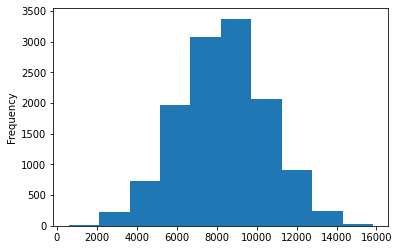

In [121]:
word_scores_df.score.plot.hist()

In [149]:
LIMIT = 1000
high_scores_df = word_scores_df.head(LIMIT).copy()
high_scores_df['word_set'] = high_scores_df.word.apply(lambda w: set(w))

In [151]:
len(high_scores_df)

1000

In [175]:
{1, 2} - {3} == {1, 2}

True

In [177]:
def find_matches(ignore_index, current_word_set):
    matches = []
    for i, word_row in enumerate(high_scores_df.itertuples()):
#         print(word_row)
        if i != ignore_index:
#             print(i, word_row.word_set)
            
            word_diff = current_word_set - word_row.word_set
            if word_diff == current_word_set:
                matches.append(word_row)
    return matches

In [186]:
def highest_score_matches(word_matches):
    highest_score_word_match = None
    for i, word_match in enumerate(word_matches):
        if highest_score_word_match is None or word_match.score > highest_score_word_match.score:
            highest_score_word_match = word_match
    return highest_score_word_match
        

In [198]:
word_groups = []
for i, word_row in enumerate(high_scores_df.itertuples()):
    word_set = word_row.word_set
    word_matches = find_matches(i, word_set)
    best_match = highest_score_matches(word_matches)
    if best_match is not None:
        word_groups.append({
            'word1': word_row.word,
            'word2': best_match.word,
            'score': word_row.score + best_match.score
        })


In [199]:
highest_scoring_groups = sorted(word_groups, key = lambda row: row['score'], reverse=True)

In [200]:
highest_scoring_groups[:10]

[{'word1': 'baris', 'word2': 'coney', 'score': 28060},
 {'word1': 'coney', 'word2': 'baris', 'score': 28060},
 {'word1': 'taney', 'word2': 'boris', 'score': 27888},
 {'word1': 'boris', 'word2': 'taney', 'score': 27888},
 {'word1': 'paris', 'word2': 'boney', 'score': 27760},
 {'word1': 'boney', 'word2': 'paris', 'score': 27760},
 {'word1': 'poney', 'word2': 'baris', 'score': 27760},
 {'word1': 'corey', 'word2': 'talis', 'score': 27624},
 {'word1': 'talis', 'word2': 'corey', 'score': 27624},
 {'word1': 'maney', 'word2': 'boris', 'score': 27570}]

In [ ]:
word_sets_matches = []